In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from astropy.io import fits
from scipy.interpolate import RectBivariateSpline

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (10, 500)
n_period = 101
rp_rng = (2.5, 5)
n_rp = 101

whichRadii = "corrected"

In [3]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [4]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [59]:
period = np.logspace(np.log10(10), np.log10(500), num=10)
rp = np.logspace(np.log10(2.5), np.log10(5), num=10)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [60]:
p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

In [61]:
inputgrid = "../completenessContours/out0603_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                 10.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  2.5                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [62]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

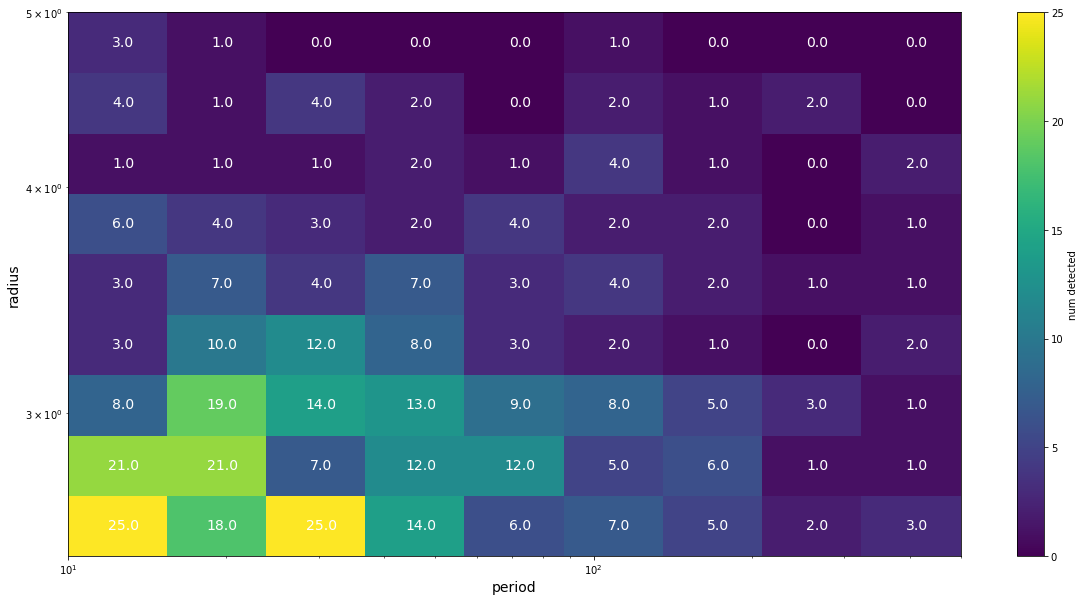

In [63]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

#plt.xlim(.1,500)
plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im, label="num detected")
#plt.savefig("10hist_p10500r255.png")
plt.show()

In [64]:
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')
#print(grid)

In [65]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

In [66]:
occ = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        occ[i, j] = np.sum(bin_.totalReliability / bin_.completeness) / kiclist.size
        
print(occ)

[[1.01728346e-02 8.55233869e-03 3.33081683e-03 1.29829154e-03
  1.14937849e-03 1.72462830e-03 6.93896508e-05 1.49871843e-03
  1.25317516e-03]
 [9.28452623e-03 1.17235609e-02 9.92912293e-03 5.25986386e-03
  3.70931929e-03 2.02932107e-03 6.00276845e-04 5.73233693e-04
  4.94825949e-04]
 [1.92283815e-02 4.86006868e-03 1.02553896e-02 8.67200498e-03
  2.79248135e-03 1.15321523e-03 2.59236524e-04 2.77202486e-03
  0.00000000e+00]
 [1.43344097e-02 1.20396420e-02 1.21609521e-02 7.96001380e-03
  5.93724053e-03 9.02655719e-04 1.92866955e-03 1.20670200e-03
  0.00000000e+00]
 [9.05218618e-03 1.58627165e-02 1.20332021e-02 3.68929375e-03
  3.81009018e-03 3.15585781e-03 8.35599667e-04 0.00000000e+00
  0.00000000e+00]
 [1.37450351e-02 9.92447556e-03 1.34675317e-02 3.95833897e-03
  7.05976742e-03 3.32193296e-03 5.06061834e-03 3.27230890e-03
  1.89897416e-05]
 [1.40794662e-02 1.67508301e-02 1.12712665e-02 2.40290135e-03
  2.62869049e-03 4.56046039e-03 2.30978617e-03 2.16786786e-03
  0.00000000e+00]
 [8.86

In [67]:
b = kois[((kois.koi_period < 188.03015465) & (kois.koi_period > 70.71067812) & 
                     (kois.kois_rp < 5) & (kois.kois_rp > 2.5))]
np.sum(b.totalReliability / b.completeness) / kiclist.size

0.13521434213240302

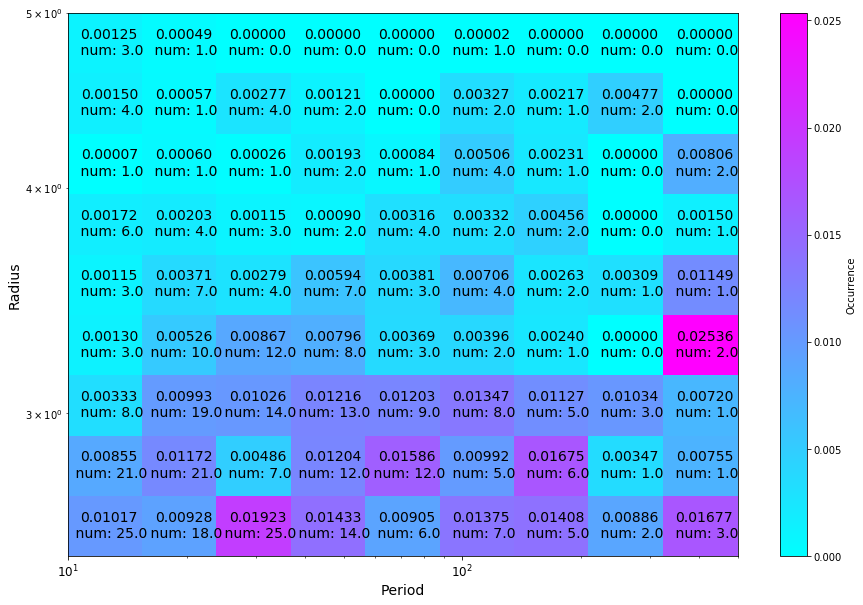

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.pcolormesh(period_grid, rp_grid, occ, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % occ.T[i,j]) + '\n num: ' + str(H.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='large')
               
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


TypeError: Dimensions of C (4, 4) are incompatible with X (10) and/or Y (10); see help(pcolormesh)

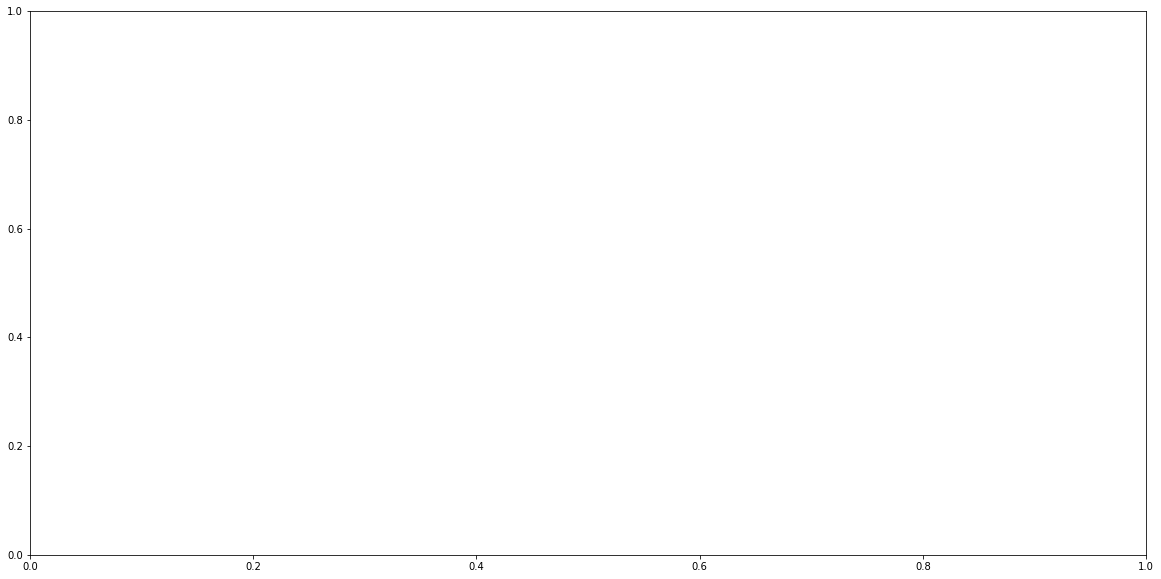

In [71]:
exp = occ * kiclist.size
exp_err = np.sqrt(H)/H * exp

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, ex, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % exp.T[i,j]) + r" $\pm$ " + str("%.5f" % exp_err.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

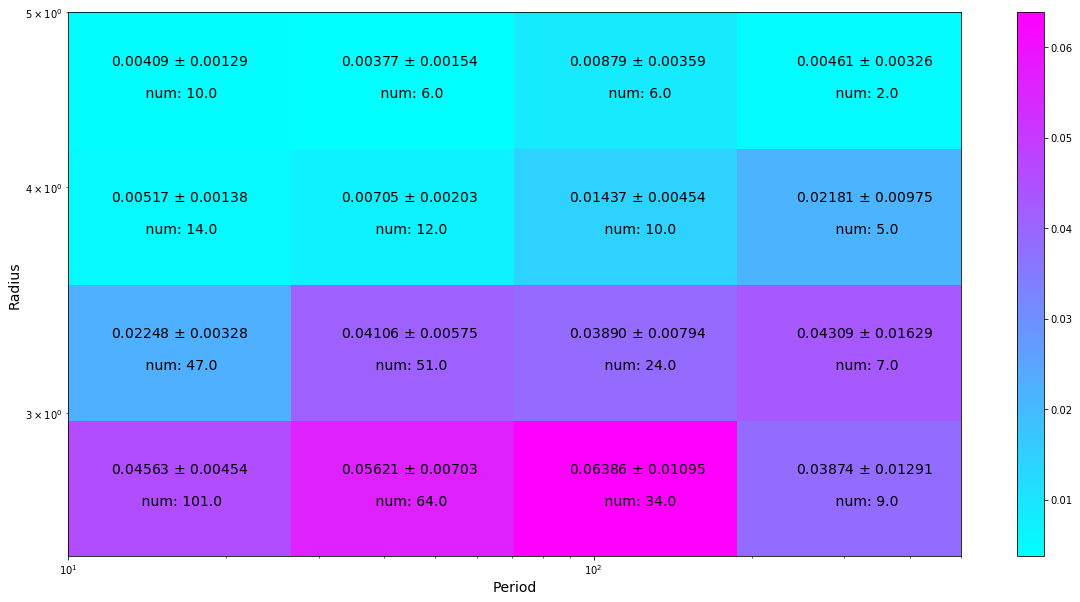

In [58]:
o = exp / kiclist.size
err = np.sqrt(H) * exp / (kiclist.size *H)
offset=[2, 4, 8, 16]

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, o, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        #err = occ.T[i,j] / np.sqrt(H.T[i,j])
        t = str("%.5f" % o.T[i,j]) + r" $\pm$ " + str("%.5f" % err.T[i,j]) + '\n\n num: ' + str(H.T[i,j])
        ax.text(xcent[j]-offset[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

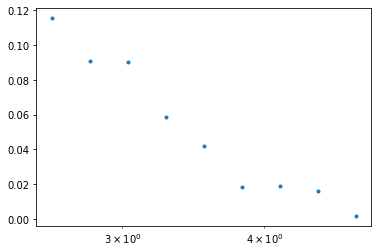

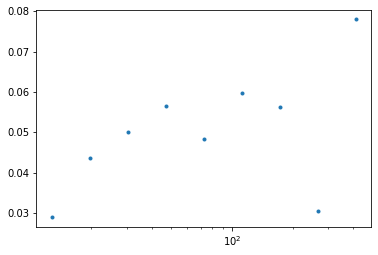

In [72]:
plt.figure()
plt.plot(r_cent, np.sum(occ, axis=0), '.')
plt.xscale('log')

plt.figure()
plt.plot(p_cent, np.sum(occ, axis=1), '.')
plt.xscale('log')

plt.show()

[ 2.14576763e-05 -2.59598515e-01  5.37978923e-02]
[-3.63108251  3.9493533 ]


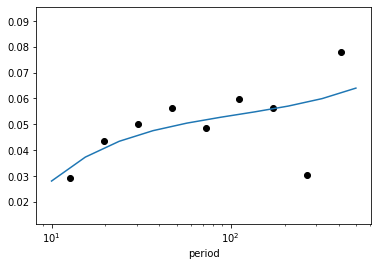

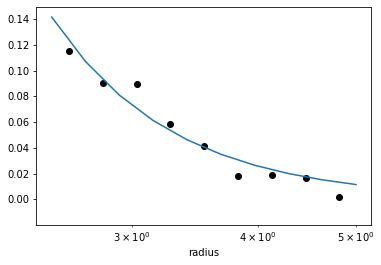

In [73]:
def power_law(x, alpha, f0):
    r = f0 * x**alpha
    return(r)

def asymp(x, a, b, c):
    r = a*x + (b/x) + c
    return(r)

popt, pcov = curve_fit(asymp, p_cent, np.sum(occ, axis=1))
print(popt)

plt.figure()
plt.scatter(p_cent, np.sum(occ, axis=1), color='k')
#plt.errorbar(p_cent, np.sum(occ, axis=1), yerr=np.sum(err, axis=1), fmt='.k')
plt.plot(period, asymp(period, *popt))
plt.xscale('log')
plt.xlabel('period')

popt, pcov = curve_fit(power_law, r_cent, np.sum(occ, axis=0))
print(popt)

plt.figure()
plt.scatter(r_cent, np.sum(occ, axis=0), color='k')
#plt.errorbar(r_cent, np.sum(occ, axis=0), yerr=np.sum(err, axis=1), fmt='.k')
plt.plot(rp, power_law(rp, *popt))
plt.xscale('log')
plt.xlabel('radius')
plt.show()

(4, 4)
[-0.41017554 -5.49158334  3.38176724 -0.61838482]
(16,)


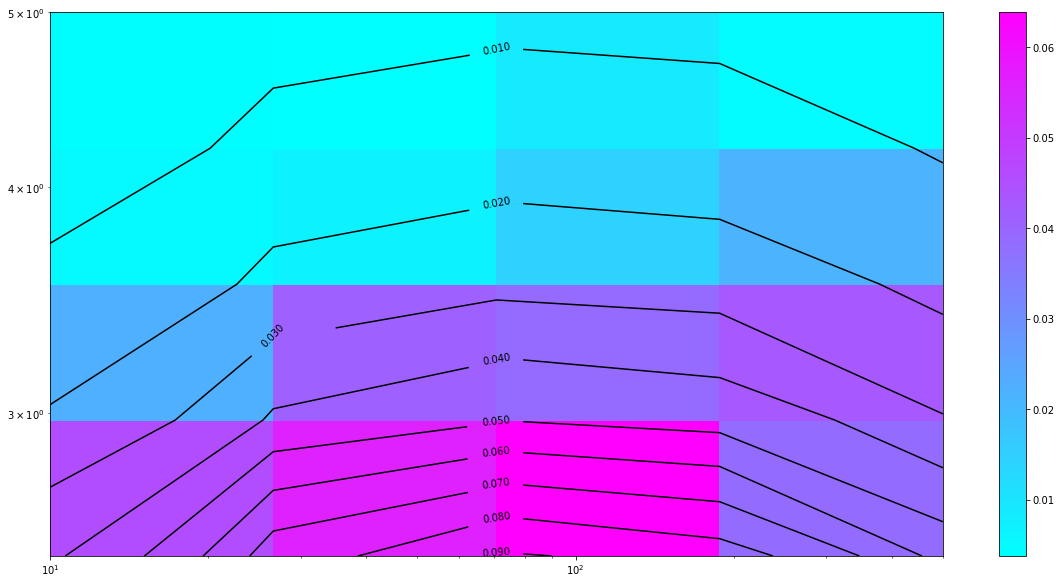

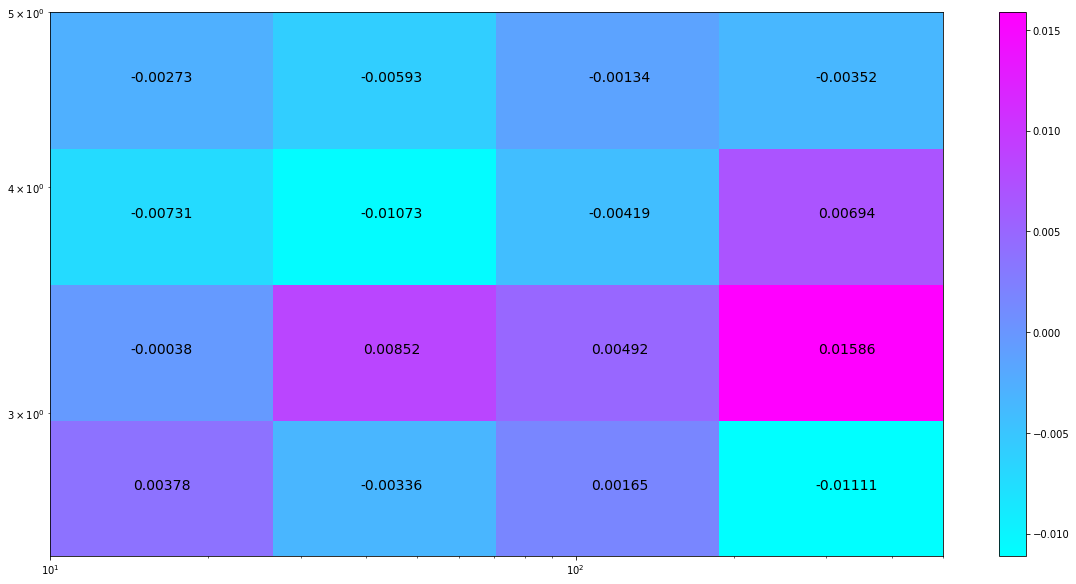

In [32]:
def powerYasympX(xdata_tuple, a, b, c, alpha):
    (x, y) = xdata_tuple
    xd = a*y + (b/y) + c
    yd = x**alpha
    r = xd*yd
    return(r.ravel())

p, r = np.meshgrid(p_cent, r_cent)
print(p.shape)
popt, pcov = curve_fit(powerYasympX, (p, r), occ.ravel())
print(popt)

d = powerYasympX((p, r), *popt)
print(d.shape)
d = d.reshape(4,4)

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, occ, cmap='cool')
CS = ax.contour(period, rp, powerYasympX((period_grid, rp_grid), *popt).reshape(5,5), 8, colors='k')
ax.clabel(CS, inline=1)

plt.colorbar(im)
plt.xscale('log')
plt.yscale('log')

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, occ-d, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % (occ-d).T[i,j])
        ax.text(xcent[j]-offset[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xscale('log')
plt.yscale('log')
plt.show()

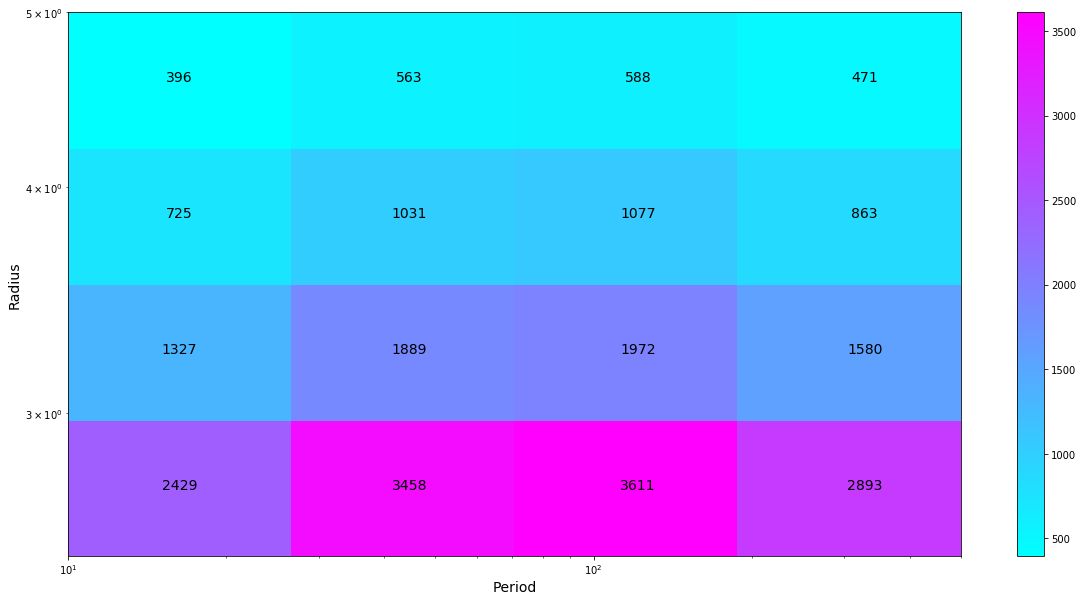

In [20]:
ex = d * kiclist.size
offset=[2, 4, 8, 16]

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, ex, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j]-offset[j], ycent[i], int(round(ex.T[i, j])), 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

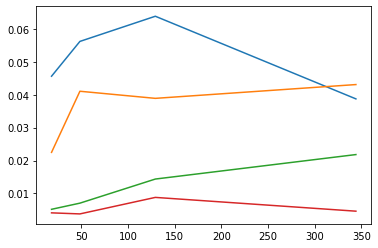

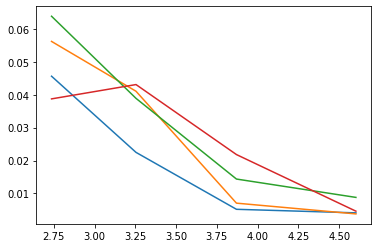

In [21]:
plt.figure()
plt.plot(p_cent, occ[:, 0])
plt.plot(p_cent, occ[:, 1])
plt.plot(p_cent, occ[:, 2])
plt.plot(p_cent, occ[:, 3])

plt.figure()
plt.plot(r_cent, occ[0, :])
plt.plot(r_cent, occ[1, :])
plt.plot(r_cent, occ[2, :])
plt.plot(r_cent, occ[3, :])
plt.show()